# Description
**This assignment focuses on learning and using simple bias mitigation methods. Therefore, we provide a baseline for data processing and model training. You can conduct this bias mitigation experiment based on this reference baseline. 
<font color=red>(note: based on this baseline, but not limited to this baseline, we encourage trying more methods)</font>**

# Loading packages

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

#Visualisation Library
import seaborn as sns
import matplotlib.pyplot as plt

#To avoid warning messages
import warnings
warnings.filterwarnings('ignore')

#Classification model 
from sklearn.linear_model import LogisticRegression

#Classification model evaluation metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

#To split the model into training and testing data
from sklearn.model_selection import train_test_split

#Different model improvement packages
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

#Evaluation metrics
from sklearn import metrics

import joblib

# Loading the dataset

In [2]:
train=pd.read_csv("../data/train.csv")
test=pd.read_csv('../data/test.csv')

#Creating a copy for backup
train_og=train.copy()
test_og=test.copy()

In [3]:
#Checking the data types of our data
train.dtypes

Loan_ID               object
Gender                object
Race                  object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

* All the object data types needs to be converted into int so we can build a model 
* Dependents has to be int which has to be looked into

In [4]:
#Checking the number of rows and columns in our dataset
train.shape,test.shape

((614, 14), (367, 13))

In [5]:
#Checking the bal of target variable
train["Loan_Status"].value_counts(normalize=True)

Loan_Status
Y    0.687296
N    0.312704
Name: proportion, dtype: float64

* There isn't a good balance between our target which needs to be managed using ROS method or stratify

# Visualising Categorical variables

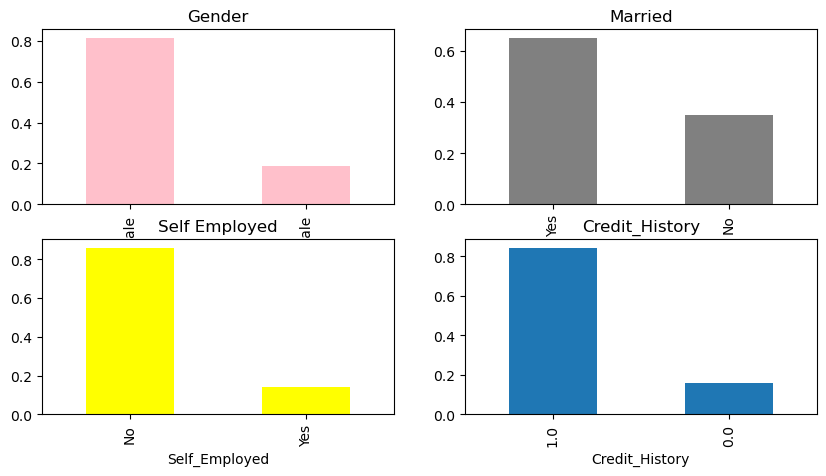

In [6]:
plt.figure(1) 
plt.subplot(2,2,1)
train['Gender'].value_counts(normalize=True).plot.bar(figsize=(10,5),title='Gender',color='pink')
plt.subplot(2,2,2)
train['Married'].value_counts(normalize=True).plot.bar(figsize=(10,5),title='Married',color='grey')
plt.subplot(2,2,3)
train['Self_Employed'].value_counts(normalize=True).plot.bar(figsize=(10,5),title='Self Employed',color='yellow')
plt.subplot(2,2,4)
train['Credit_History'].value_counts(normalize=True).plot.bar(figsize=(10,5),title='Credit_History')
plt.show()

Most loan Applicants are male, married and not self_employed with a 1.0 credit history

# Visualising Ordinal Variable

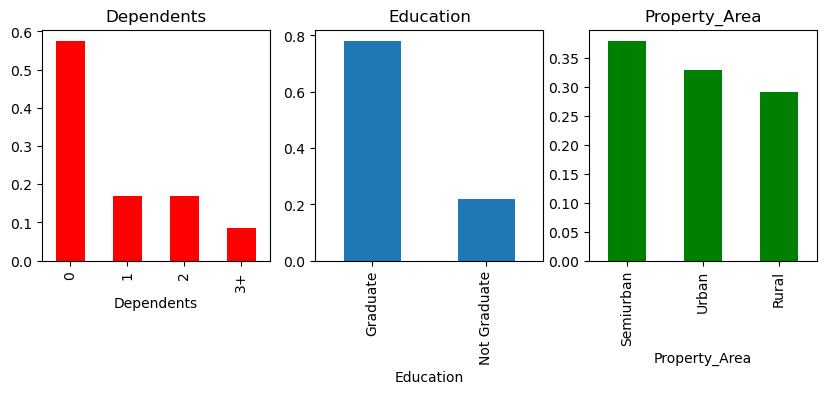

In [7]:
plt.figure(1)
plt.subplot(1,3,1)
train['Dependents'].value_counts(normalize=True).plot.bar(figsize=(10,3),title='Dependents',color='red')
plt.subplot(1,3,2)
train['Education'].value_counts(normalize=True).plot.bar(figsize=(10,3),title='Education')
plt.subplot(1,3,3)
train['Property_Area'].value_counts(normalize=True).plot.bar(figsize=(10,3),title='Property_Area',color='green')
plt.show()

Most applicants dont have dependents are graduates and belong from semiurban area

In [8]:
train['Dependents']=train['Dependents'].replace('3+','3')

# Visualising Numeric Variables and checking for outliers

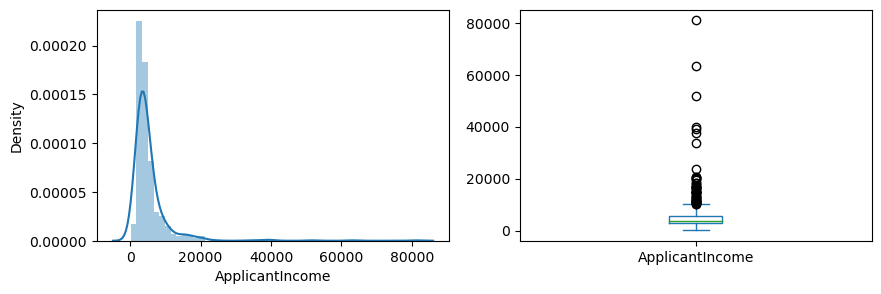

In [9]:
plt.figure(1)
plt.subplot(1,2,1)
sns.distplot(train['ApplicantIncome'])
plt.subplot(1,2,2)
train['ApplicantIncome'].plot.box(figsize=(10,3))
plt.show()

We can observe that there is high left skewness in the applicant income which means there are outliers which needs to be treated before we build our model

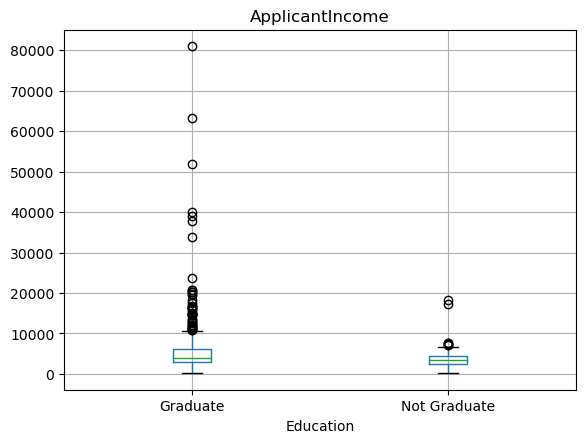

In [10]:
#Visualizing the application income considering whether applicant is graduate or not
train.boxplot(column='ApplicantIncome',by='Education')
plt.suptitle("")
plt.show()

We can observe that most anomalies are in case of Graduates compared to non graduates

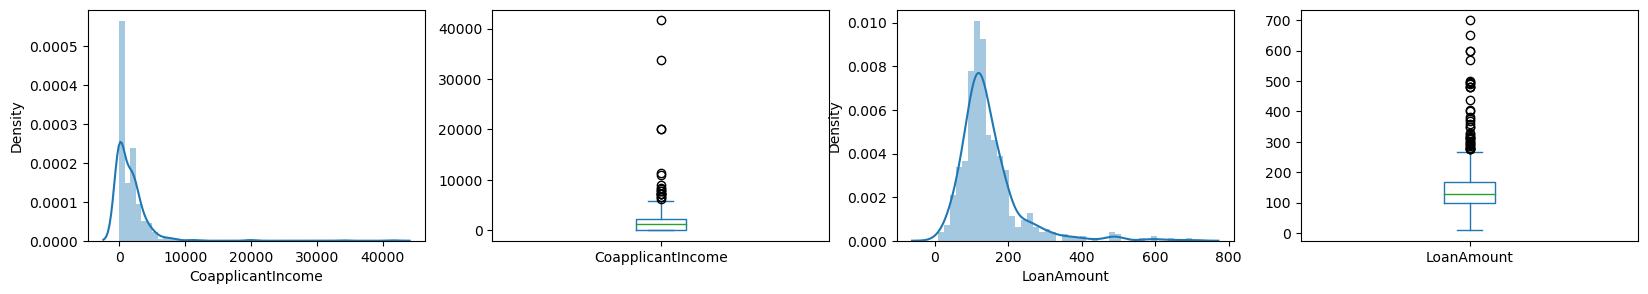

In [11]:
plt.figure(1)
plt.subplot(1,4,1)
sns.distplot(train['CoapplicantIncome'])
plt.subplot(1,4,2)
train['CoapplicantIncome'].plot.box(figsize=(20,3))
plt.subplot(1,4,3)
sns.distplot(train['LoanAmount'])
plt.subplot(1,4,4)
train['LoanAmount'].plot.box()
plt.show()

Theres high skewnesss for coapplicant income and light skewness in case of loan amount

# Bivariate Analysis

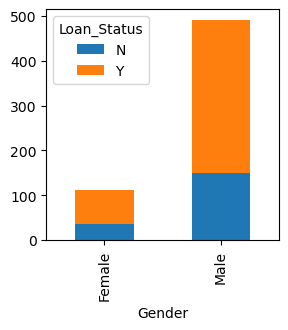

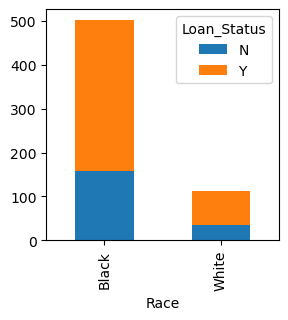

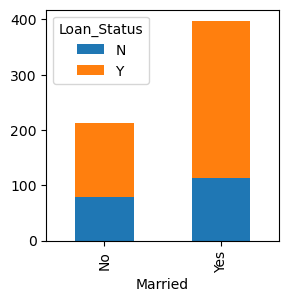

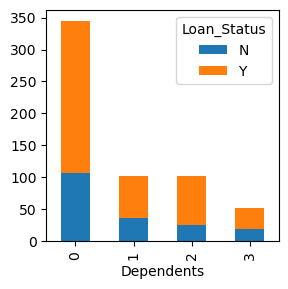

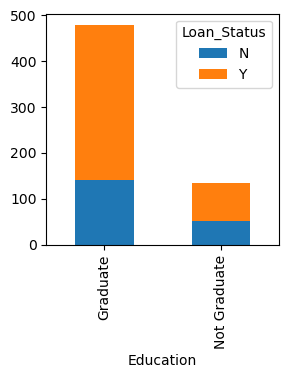

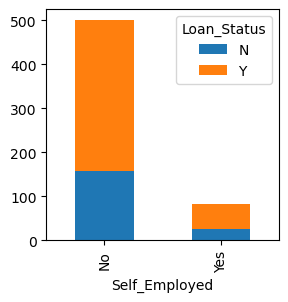

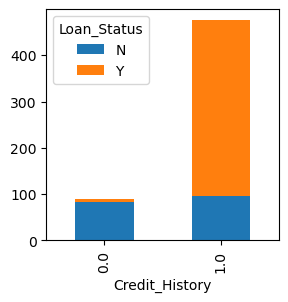

In [12]:
gender=pd.crosstab(train['Gender'],train['Loan_Status'])
gender.plot(kind='bar',stacked=True,figsize=(3,3))

gender=pd.crosstab(train['Race'],train['Loan_Status'])
gender.plot(kind='bar',stacked=True,figsize=(3,3))

married=pd.crosstab(train['Married'],train['Loan_Status'])
married.plot(kind='bar',stacked=True,figsize=(3,3))

dependents=pd.crosstab(train['Dependents'],train['Loan_Status'])
dependents.plot(kind='bar',stacked=True,figsize=(3,3))

education=pd.crosstab(train['Education'],train['Loan_Status'])
education.plot(kind='bar',stacked=True,figsize=(3,3))

selfemployed=pd.crosstab(train['Self_Employed'],train['Loan_Status'])
selfemployed.plot(kind='bar',stacked=True,figsize=(3,3))

credithistory=pd.crosstab(train['Credit_History'],train['Loan_Status'])
credithistory.plot(kind='bar',stacked=True,figsize=(3,3))

plt.show()

* From the above visualisation its clear that mostly graduates, self-employed and applicants with 0 dependents have high chances of loan approval
* Applicants whose credit history is 0 have very low chances of getting loan

# Correlation of dataset

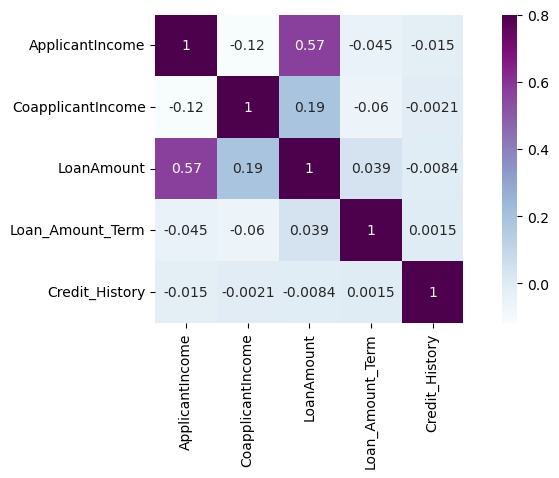

In [13]:
# Specify numeric columns
numeric_columns = train.select_dtypes(include=[np.number])

# Calculate correlation matrix
matrix = numeric_columns.corr()

# Plot heatmap
f, ax = plt.subplots(figsize=(10, 4
                              ))
sns.heatmap(matrix, vmax=0.8, square=True, cmap="BuPu", annot=True)
plt.show()


# Missing Value Imputation

In [14]:
train.isnull().sum()

Loan_ID               0
Gender               13
Race                  0
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [15]:
#Creating variables that stores all numeric and object columns
numeric_col= train.select_dtypes([int,float]).columns
object_col= train.select_dtypes([object]).columns
print('object columns: ', object_col)
print('numeric columns:' , numeric_col)

object columns:  Index(['Loan_ID', 'Gender', 'Race', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'Property_Area', 'Loan_Status'],
      dtype='object')
numeric columns: Index(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History'],
      dtype='object')


In [16]:
#Inputing the missing numeric data with mean value
for i in train[numeric_col]:
    print(i,':' ,round(train[i].mean(),2))
    train[i].fillna(round(train[i].mean(),2),inplace=True)

ApplicantIncome : 5403.46
CoapplicantIncome : 1621.25
LoanAmount : 146.41
Loan_Amount_Term : 342.0
Credit_History : 0.84


In [17]:
train.isnull().sum()

Loan_ID               0
Gender               13
Race                  0
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            0
Loan_Amount_Term      0
Credit_History        0
Property_Area         0
Loan_Status           0
dtype: int64

All the numeric missing values have been imputed 

In [18]:
#Imputing object data with mode
for i in train[object_col]:
    print(i,':', train[i].mode()[0])
    train[i].fillna(train[i].mode()[0],inplace=True)

Loan_ID : LP001002
Gender : Male
Race : Black
Married : Yes
Dependents : 0
Education : Graduate
Self_Employed : No
Property_Area : Semiurban
Loan_Status : Y


In [19]:
train.isnull().sum()

Loan_ID              0
Gender               0
Race                 0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

NO more missing values 

# Understanding the uniqueness of our data

In [20]:
#Checking the uniquness of our data
train.nunique()

Loan_ID              614
Gender                 2
Race                   2
Married                2
Dependents             4
Education              2
Self_Employed          2
ApplicantIncome      505
CoapplicantIncome    287
LoanAmount           204
Loan_Amount_Term      11
Credit_History         3
Property_Area          3
Loan_Status            2
dtype: int64

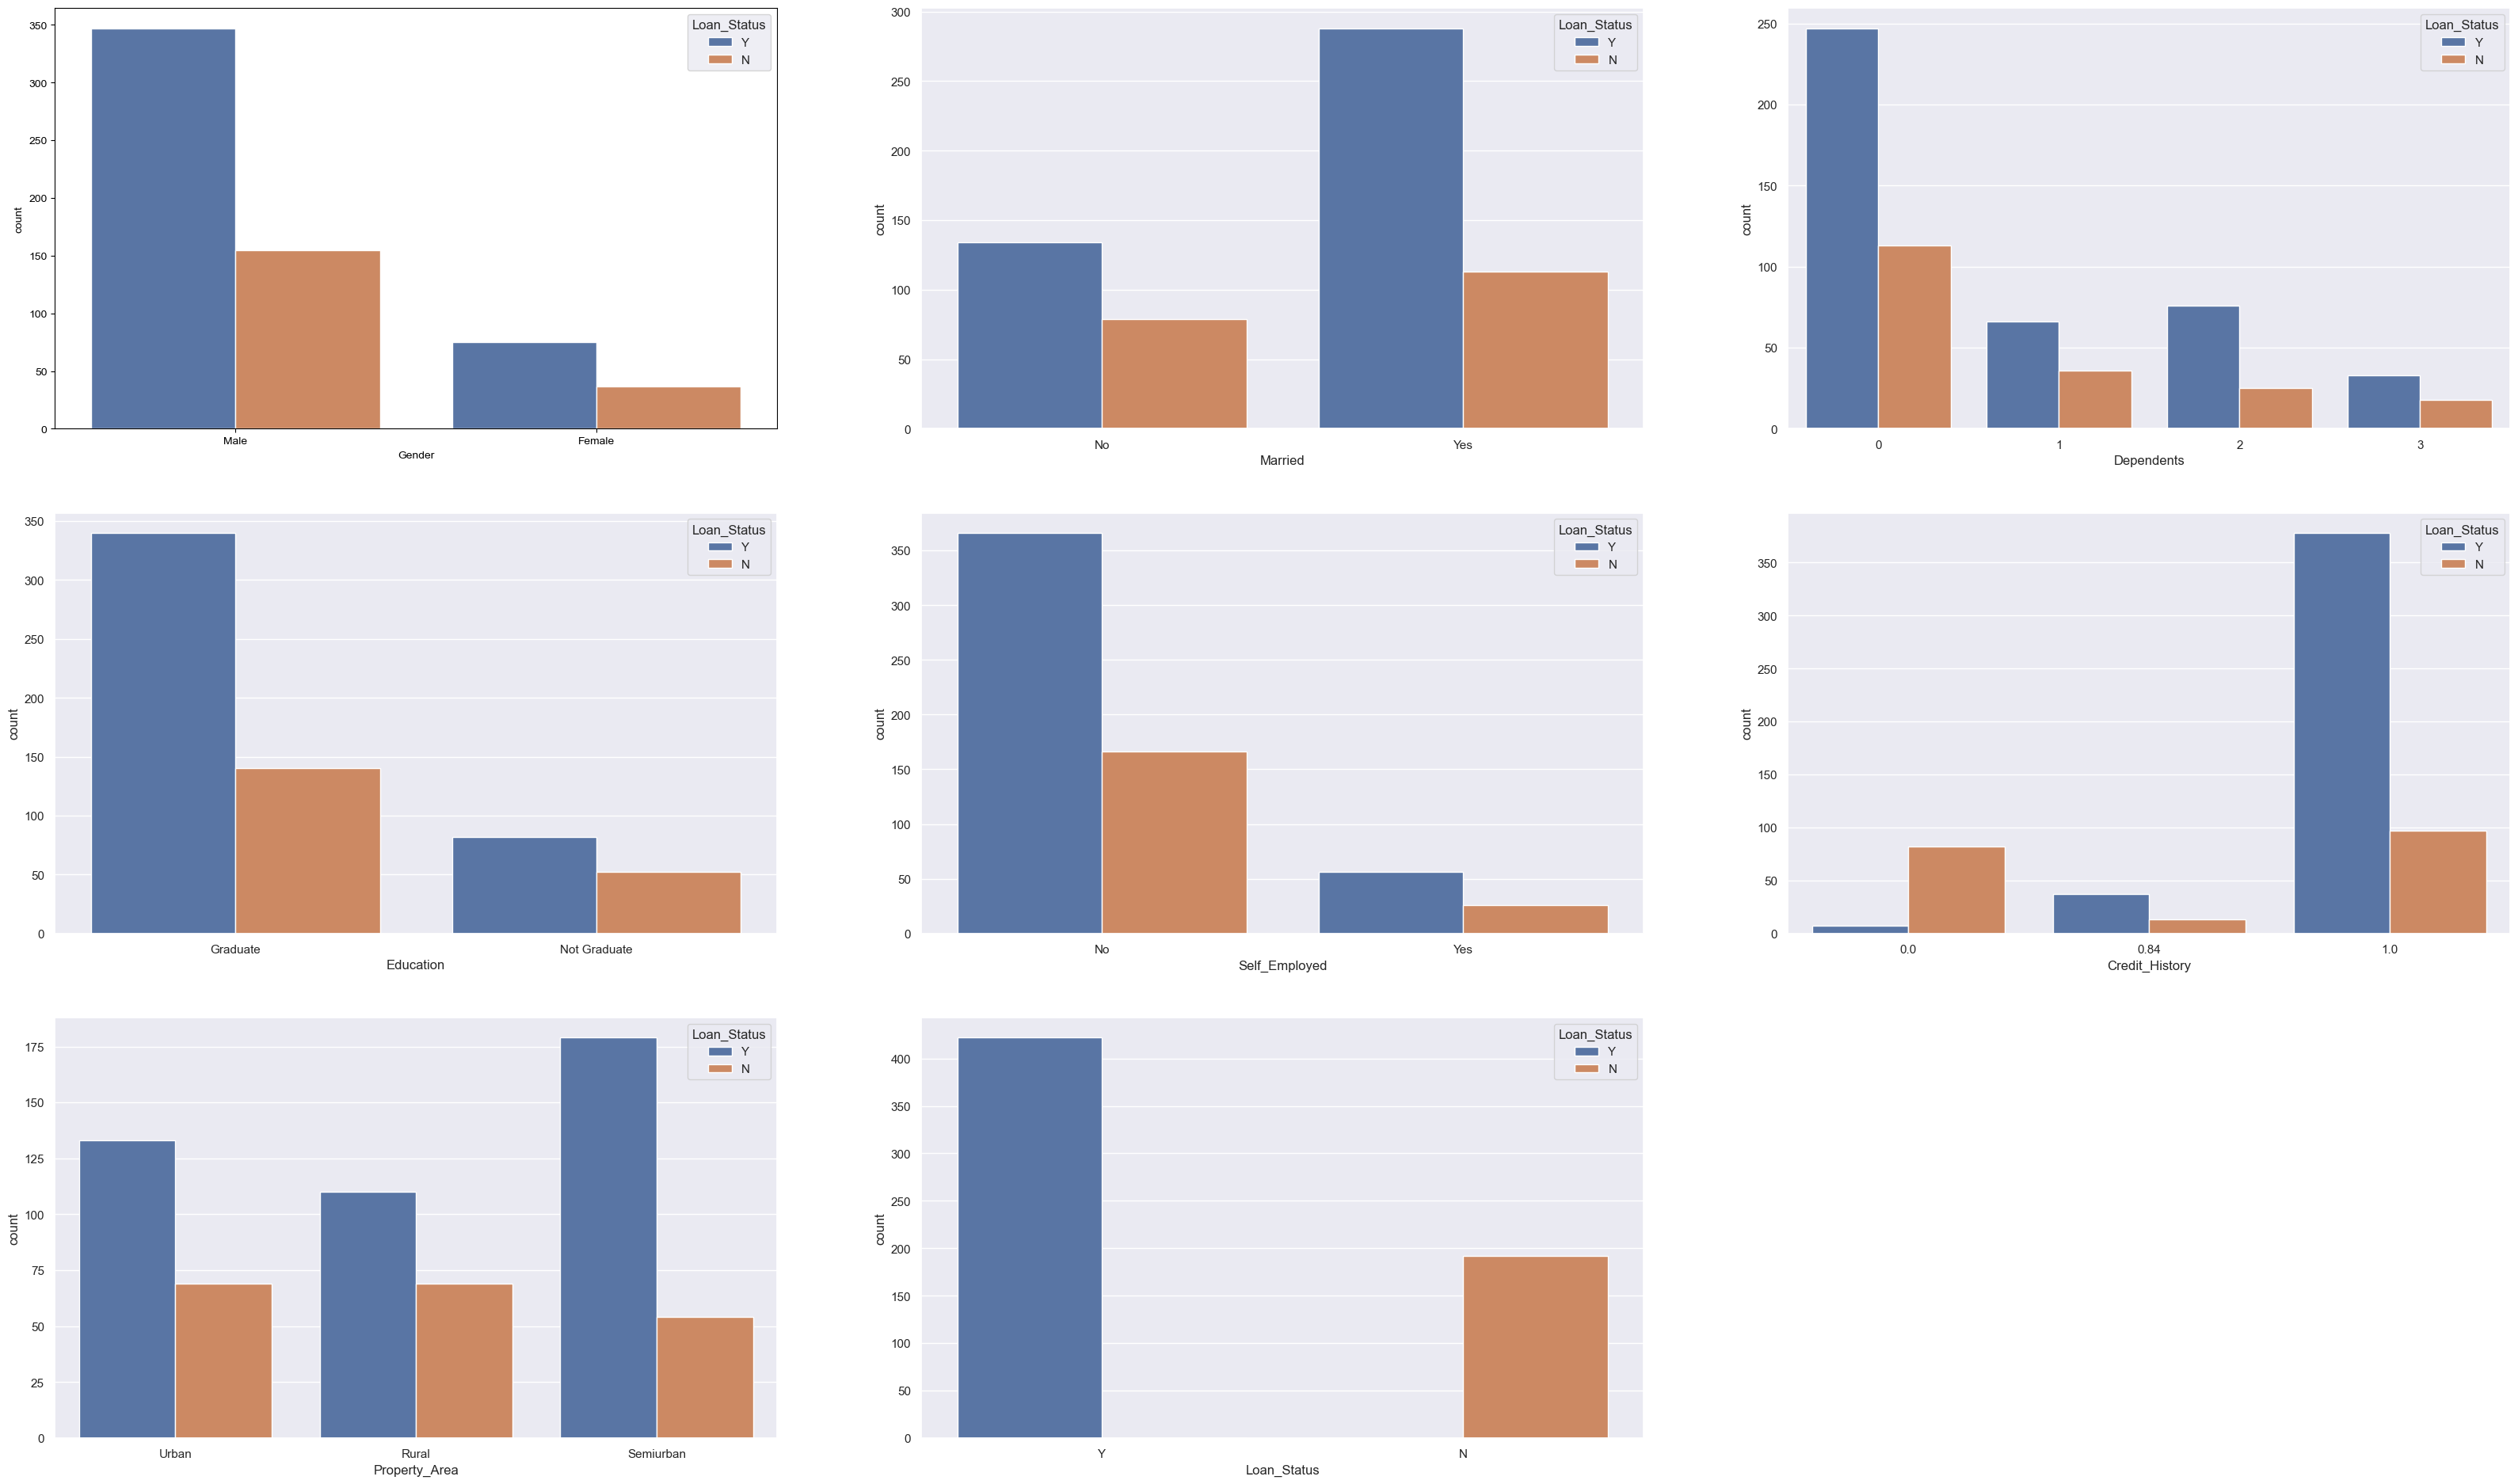

In [21]:
#Visualising features with low unique values for better understanding
v= train[['Gender','Married','Dependents','Education','Self_Employed','Credit_History','Property_Area' \
          ,'Loan_Status']].columns
plt.figure(figsize=(40,40))
for i,col in enumerate(v):
    plt.subplot(5,3,i+1)
    sns.set(style='darkgrid')
    sns.countplot(x=train[col],hue=train['Loan_Status'])
plt.show()

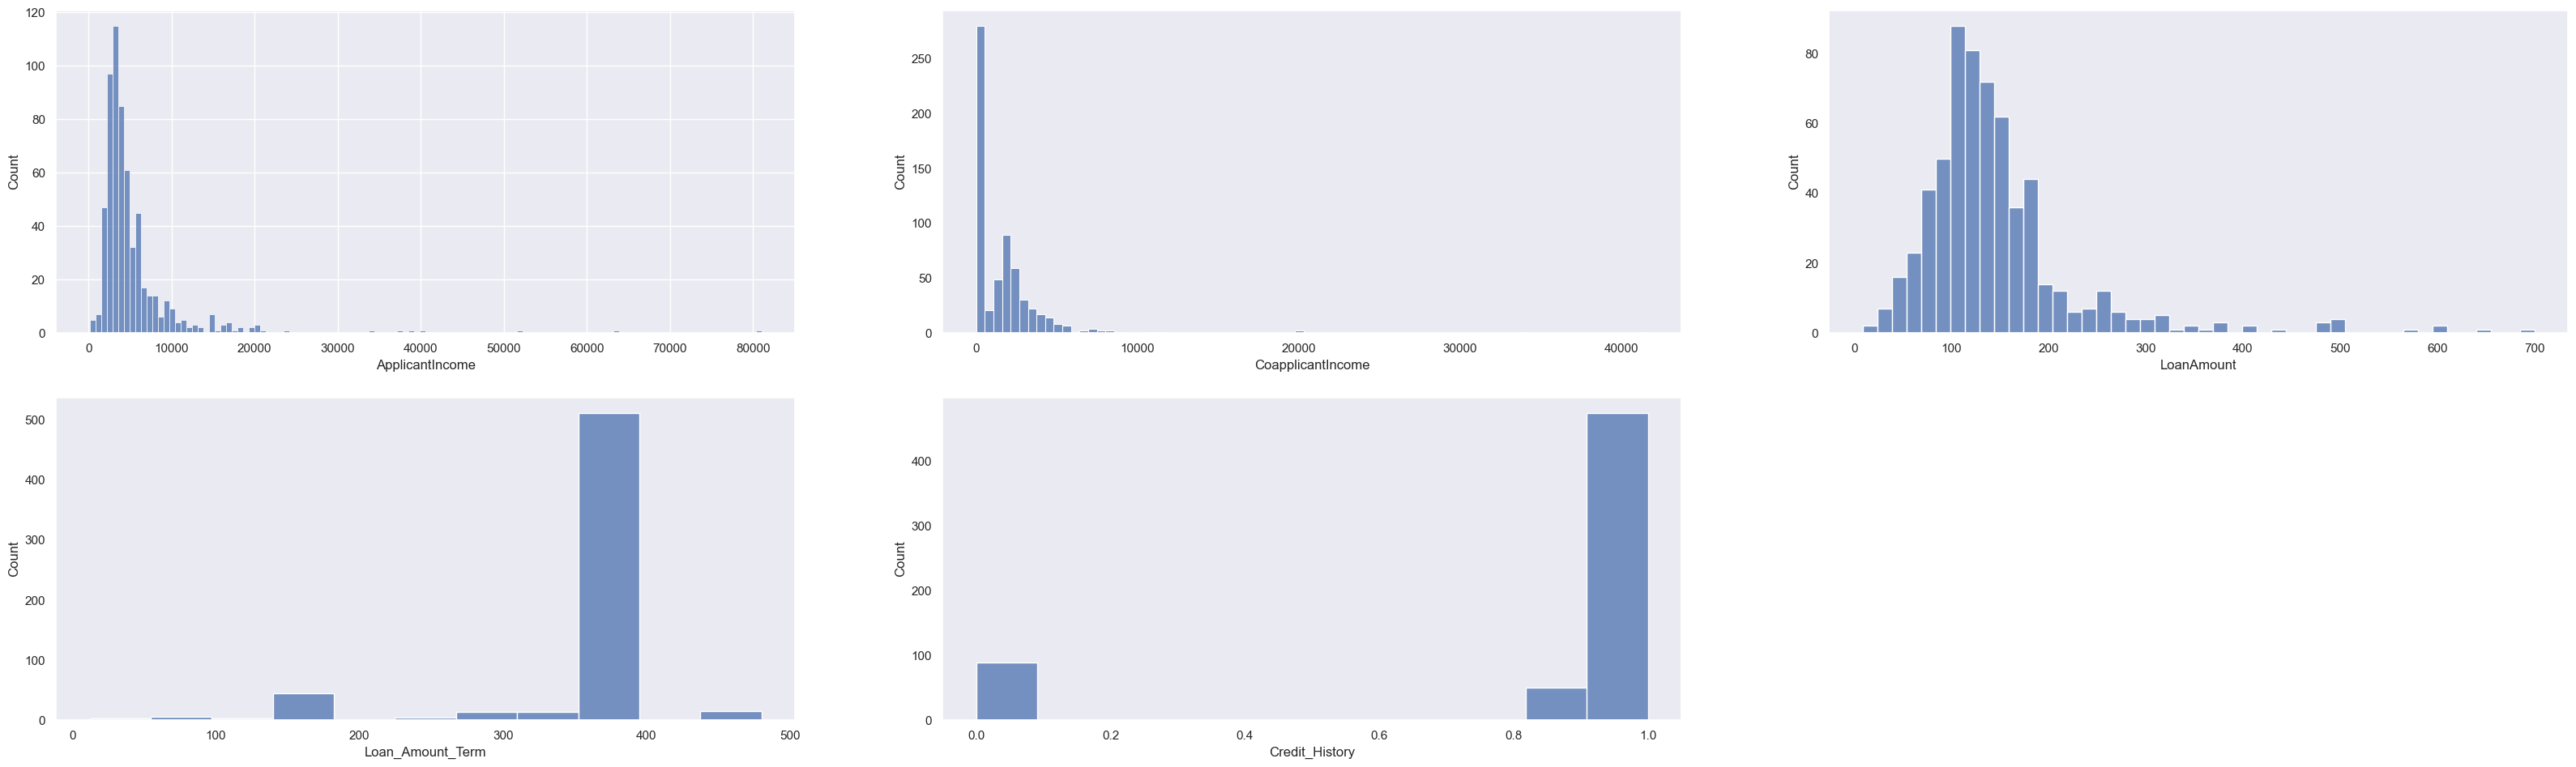

In [22]:
plt.figure(figsize=(40,30))
for i,col in enumerate(numeric_col):
    plt.subplot(5,3,i+1)
    sns.set_style('dark')
    sns.histplot(train[col])
plt.show()

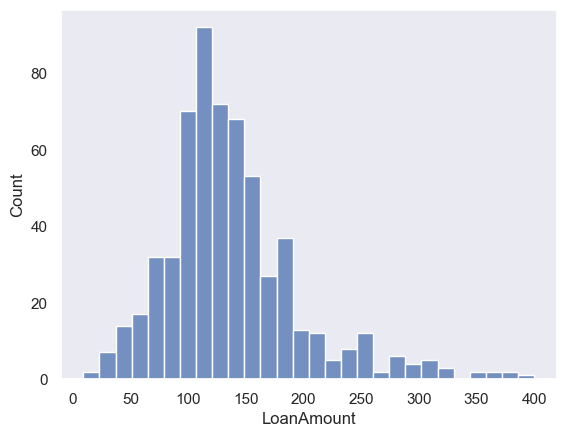

In [23]:
train.drop(train['LoanAmount'][train['LoanAmount']>400].index, inplace=True)
sns.histplot(train['LoanAmount'])
plt.show()

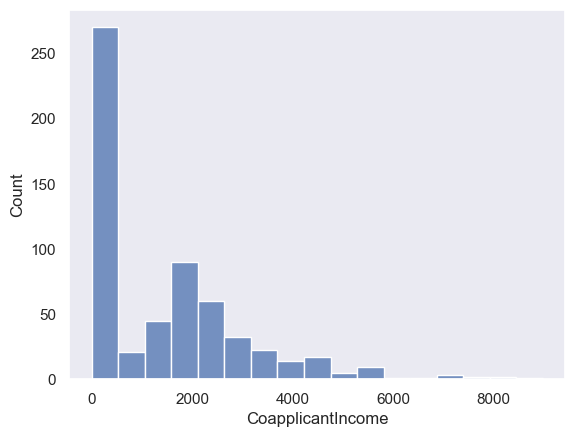

In [24]:
train.drop(train['CoapplicantIncome'][train['CoapplicantIncome']>10000].index, inplace=True)
sns.histplot(train['CoapplicantIncome'])
plt.show()

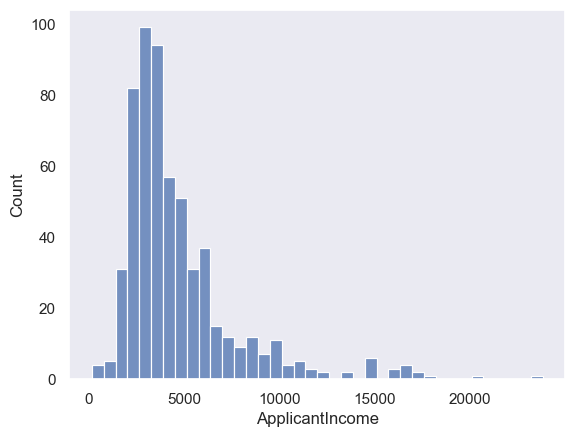

In [25]:
train.drop(train['ApplicantIncome'][train['ApplicantIncome']>25000].index, inplace=True)
sns.histplot(train['ApplicantIncome'])
plt.show()

# Treating object data types for model building

In [26]:
train.to_csv('../data/cleaned_train.csv',index=False)

In [27]:
#Chekcing the remaining columns to treat the object data types
train.columns

Index(['Loan_ID', 'Gender', 'Race', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

In [28]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 591 entries, 0 to 613
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            591 non-null    object 
 1   Gender             591 non-null    object 
 2   Race               591 non-null    object 
 3   Married            591 non-null    object 
 4   Dependents         591 non-null    object 
 5   Education          591 non-null    object 
 6   Self_Employed      591 non-null    object 
 7   ApplicantIncome    591 non-null    int64  
 8   CoapplicantIncome  591 non-null    float64
 9   LoanAmount         591 non-null    float64
 10  Loan_Amount_Term   591 non-null    float64
 11  Credit_History     591 non-null    float64
 12  Property_Area      591 non-null    object 
 13  Loan_Status        591 non-null    object 
dtypes: float64(4), int64(1), object(9)
memory usage: 69.3+ KB


In [29]:
#Converting dependents into int as it includes integer values
train['Dependents']=train['Dependents'].astype('int')

In [30]:
#Mapping the object columns to convert it into binary from and then change the data type to int
train['Married']=train['Married'].map({'Yes':1, 'No':0})
train['Education']=train['Education'].map({'Graduate':1, 'Not Graduate':0})
train['Self_Employed']=train['Self_Employed'].map({'Yes':1, 'No':0})
train['Loan_Status']=train['Loan_Status'].map({'Y':1, 'N':0})

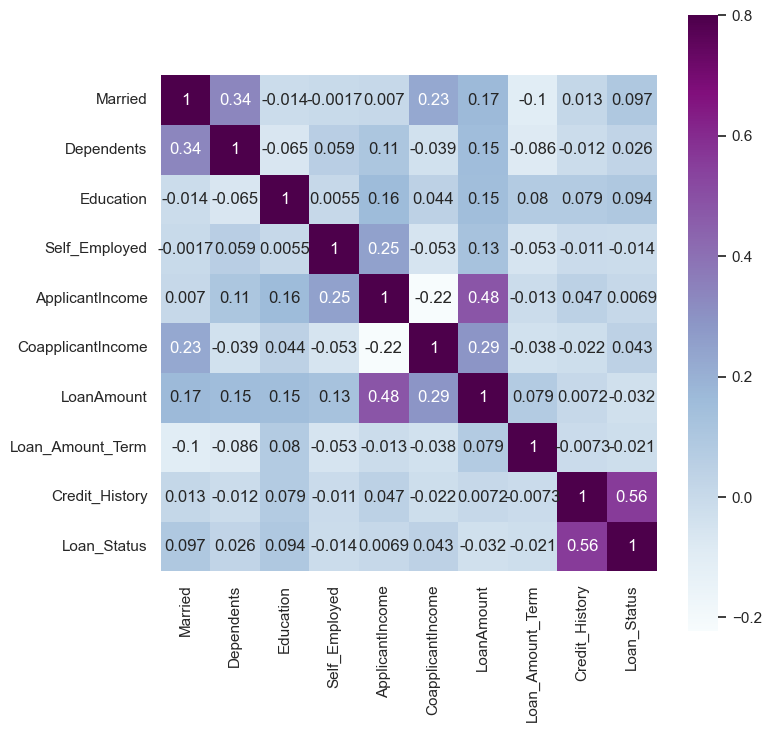

In [31]:
# Specify numeric columns
numeric_columns = train.select_dtypes(include=[np.number])

# Calculate correlation matrix
matrix = numeric_columns.corr()

# Plot heatmap
f, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(matrix, vmax=0.8, square=True, cmap="BuPu", annot=True)
plt.show()


* Loan status is highly correlated to Credit history
* we can see some multicoreniality - for eg- applicant income is highly correlated to loan amount

# Dropping redundant columns

In [32]:
train.drop('Loan_ID',axis=1, inplace=True)

In [33]:
#Using get dummies for the remaining object columns for which mapping or encoder cant be used 
train=pd.get_dummies(train)
train.head()

,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Gender_Female,Gender_Male,Race_Black,Race_White,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,0,0,1,0,5849,0.0,146.41,360.0,1.0,1,False,True,True,False,False,False,True
1,1,1,1,0,4583,1508.0,128.00,360.0,1.0,0,False,True,True,False,True,False,False
2,1,0,1,1,3000,0.0,66.00,360.0,1.0,1,False,True,True,False,False,False,True
3,1,0,0,0,2583,2358.0,120.00,360.0,1.0,1,False,True,True,False,False,False,True
4,0,0,1,0,6000,0.0,141.00,360.0,1.0,1,False,True,True,False,False,False,True


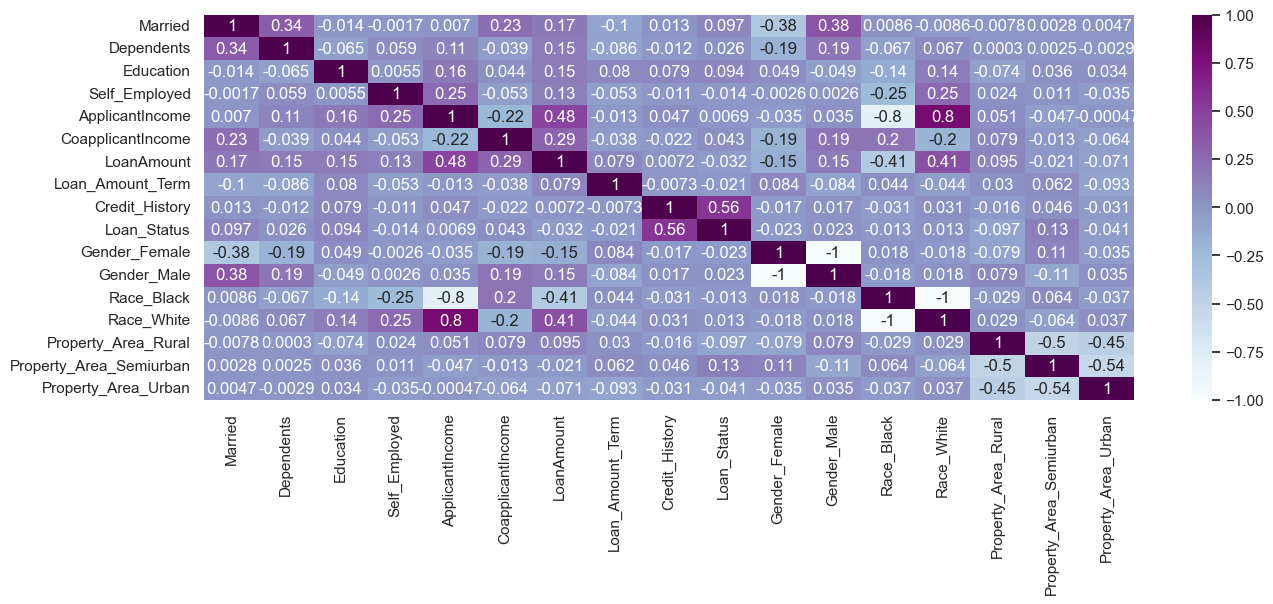

In [34]:
#Checking for correlation again now that we have treated the object columns
plt.figure(figsize=(15,5))
sns.heatmap(train.corr(),cmap='BuPu',annot=True)
plt.show()

In [35]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 591 entries, 0 to 613
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Married                  591 non-null    int64  
 1   Dependents               591 non-null    int64  
 2   Education                591 non-null    int64  
 3   Self_Employed            591 non-null    int64  
 4   ApplicantIncome          591 non-null    int64  
 5   CoapplicantIncome        591 non-null    float64
 6   LoanAmount               591 non-null    float64
 7   Loan_Amount_Term         591 non-null    float64
 8   Credit_History           591 non-null    float64
 9   Loan_Status              591 non-null    int64  
 10  Gender_Female            591 non-null    bool   
 11  Gender_Male              591 non-null    bool   
 12  Race_Black               591 non-null    bool   
 13  Race_White               591 non-null    bool   
 14  Property_Area_Rural      591 no

Finally all the object columns are treated and there are no null values in our data so we can start working on model building

# Model building

In [36]:
#Spliting the dataset into features and target
x=train.drop('Loan_Status',axis=1)
y=train['Loan_Status']

In [37]:
#Further splitting the dataset into training and testing data
xtrain,xtest,ytrain,ytest= train_test_split(x,y,test_size=0.15,stratify=y)

In [38]:
#Using logistic regression supervised ML classification model
lr=LogisticRegression()
lr.fit(xtrain,ytrain)

LogisticRegression()

In [39]:
ypred=lr.predict(xtest)
print(accuracy_score(ytest,ypred))
print(confusion_matrix(ytest,ypred))
print(classification_report(ytest,ypred))

0.7865168539325843
[[10 17]
 [ 2 60]]
              precision    recall  f1-score   support

           0       0.83      0.37      0.51        27
           1       0.78      0.97      0.86        62

    accuracy                           0.79        89
   macro avg       0.81      0.67      0.69        89
weighted avg       0.80      0.79      0.76        89



# Stratified K-Folds

In [40]:
kf=StratifiedKFold(n_splits=5, random_state=1, shuffle= True)
i=1
for train_index,test_index in kf.split(x,y):
    global model
    print('{} of kfold {}'.format(i,kf.n_splits))
    xtr,xvl=x.iloc[train_index],x.iloc[test_index]
    ytr,yvl=y.iloc[train_index],y.iloc[test_index]    
    model=LogisticRegression(random_state=1)
    model.fit(xtr,ytr)
    pred_test=model.predict(xvl)
    score=accuracy_score(yvl,pred_test)
    print('Accuracy score: ', score)
    i+=1
    pred_test =model.predict(xtest)
    pred= model.predict_proba(xvl)[:,1]
    
   

1 of kfold 5
Accuracy score:  0.8151260504201681
2 of kfold 5
Accuracy score:  0.7966101694915254
3 of kfold 5
Accuracy score:  0.8135593220338984
4 of kfold 5
Accuracy score:  0.7966101694915254
5 of kfold 5
Accuracy score:  0.8220338983050848


# ROC-AUC Curve 

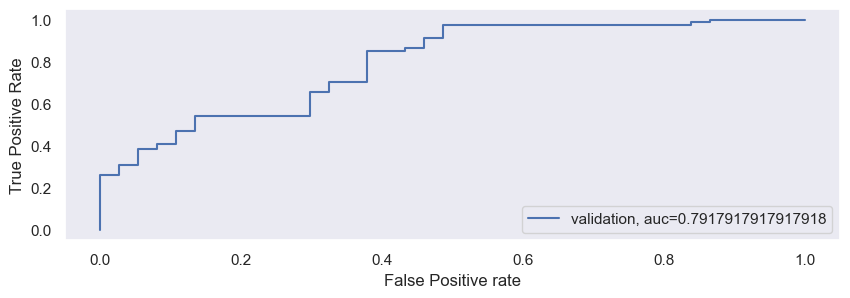

In [41]:
fpr,tpr,_=metrics.roc_curve(yvl,pred)
auc=metrics.roc_auc_score(yvl,pred)
plt.figure(figsize=(10,3))
plt.plot(fpr,tpr,label='validation, auc='+str(auc))
plt.xlabel('False Positive rate')
plt.ylabel('True Positive Rate')   
plt.legend(loc=4)
plt.show()

# Submission

In [42]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367 entries, 0 to 366
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            367 non-null    object 
 1   Gender             356 non-null    object 
 2   Race               367 non-null    object 
 3   Married            367 non-null    object 
 4   Dependents         357 non-null    object 
 5   Education          367 non-null    object 
 6   Self_Employed      344 non-null    object 
 7   ApplicantIncome    367 non-null    int64  
 8   CoapplicantIncome  367 non-null    int64  
 9   LoanAmount         362 non-null    float64
 10  Loan_Amount_Term   361 non-null    float64
 11  Credit_History     367 non-null    int64  
 12  Property_Area      367 non-null    object 
dtypes: float64(2), int64(3), object(8)
memory usage: 37.4+ KB


In [43]:
test['Gender'].fillna(test['Gender'].mode()[0],inplace=True)
test['Dependents'].fillna(test['Dependents'].mode()[0],inplace=True)
test['Self_Employed'].fillna(test['Self_Employed'].mode()[0],inplace=True)
test['LoanAmount'].fillna(test['LoanAmount'].mean(),inplace=True)
test['Loan_Amount_Term'].fillna(test['Loan_Amount_Term'].mean(),inplace=True)
test['Credit_History'].fillna(test['Credit_History'].mean(),inplace=True)

In [44]:
test['Dependents']=test['Dependents'].replace('3+',3)
test['Dependents']=test['Dependents'].astype(int)

In [45]:
test.drop('Loan_ID',axis=1, inplace=True)
test['Married']=test['Married'].map({'Yes':1, 'No':0})
test['Self_Employed']=test['Self_Employed'].map({'Yes':1, 'No':0})
test['Education']=test['Education'].map({'Graduate':1, 'Not Graduate':0})

In [46]:
test=pd.get_dummies(test)
test.head()

,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Female,Gender_Male,Race_Black,Race_White,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,1,0,1,0,5720,0,110.0,360.0,1,False,True,True,False,False,False,True
1,1,1,1,0,3076,1500,126.0,360.0,1,False,True,True,False,False,False,True
2,1,2,1,0,5000,1800,208.0,360.0,1,False,True,True,False,False,False,True
3,0,0,0,0,3276,0,78.0,360.0,1,False,True,True,False,False,False,True
4,1,0,0,1,2165,3422,152.0,360.0,1,False,True,True,False,False,False,True


In [47]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367 entries, 0 to 366
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Married                  367 non-null    int64  
 1   Dependents               367 non-null    int64  
 2   Education                367 non-null    int64  
 3   Self_Employed            367 non-null    int64  
 4   ApplicantIncome          367 non-null    int64  
 5   CoapplicantIncome        367 non-null    int64  
 6   LoanAmount               367 non-null    float64
 7   Loan_Amount_Term         367 non-null    float64
 8   Credit_History           367 non-null    int64  
 9   Gender_Female            367 non-null    bool   
 10  Gender_Male              367 non-null    bool   
 11  Race_Black               367 non-null    bool   
 12  Race_White               367 non-null    bool   
 13  Property_Area_Rural      367 non-null    bool   
 14  Property_Area_Semiurban  3

In [48]:
pred_test=model.predict(test)

In [49]:
test.head()

,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Female,Gender_Male,Race_Black,Race_White,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,1,0,1,0,5720,0,110.0,360.0,1,False,True,True,False,False,False,True
1,1,1,1,0,3076,1500,126.0,360.0,1,False,True,True,False,False,False,True
2,1,2,1,0,5000,1800,208.0,360.0,1,False,True,True,False,False,False,True
3,0,0,0,0,3276,0,78.0,360.0,1,False,True,True,False,False,False,True
4,1,0,0,1,2165,3422,152.0,360.0,1,False,True,True,False,False,False,True


In [50]:
test_og.head()

,Loan_ID,Gender,Race,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001015,Male,Black,Yes,0,Graduate,No,5720,0,110.0,360.0,1,Urban
1,LP001022,Male,Black,Yes,1,Graduate,No,3076,1500,126.0,360.0,1,Urban
2,LP001031,Male,Black,Yes,2,Graduate,No,5000,1800,208.0,360.0,1,Urban
3,LP001051,Male,Black,No,0,Not Graduate,No,3276,0,78.0,360.0,1,Urban
4,LP001054,Male,Black,Yes,0,Not Graduate,Yes,2165,3422,152.0,360.0,1,Urban


In [51]:
test_og.isnull().sum()

Loan_ID               0
Gender               11
Race                  0
Married               0
Dependents           10
Education             0
Self_Employed        23
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            5
Loan_Amount_Term      6
Credit_History        0
Property_Area         0
dtype: int64

In [52]:
test_og['Gender'].fillna(test_og['Gender'].mode()[0],inplace=True)

In [53]:
test_og.isnull().sum()

Loan_ID               0
Gender                0
Race                  0
Married               0
Dependents           10
Education             0
Self_Employed        23
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            5
Loan_Amount_Term      6
Credit_History        0
Property_Area         0
dtype: int64

In [54]:
len(test), len(test_og)

(367, 367)

In [55]:
submission=pd.DataFrame()
submission['Loan_ID']=test_og['Loan_ID']
submission['Loan_Status']=pred_test
submission['Gender'] = test_og['Gender']
submission['Race'] = test_og['Race']

In [56]:
submission.head()

,Loan_ID,Loan_Status,Gender,Race
0,LP001015,1,Male,Black
1,LP001022,1,Male,Black
2,LP001031,1,Male,Black
3,LP001051,1,Male,Black
4,LP001054,1,Male,Black


# Feature Engineering

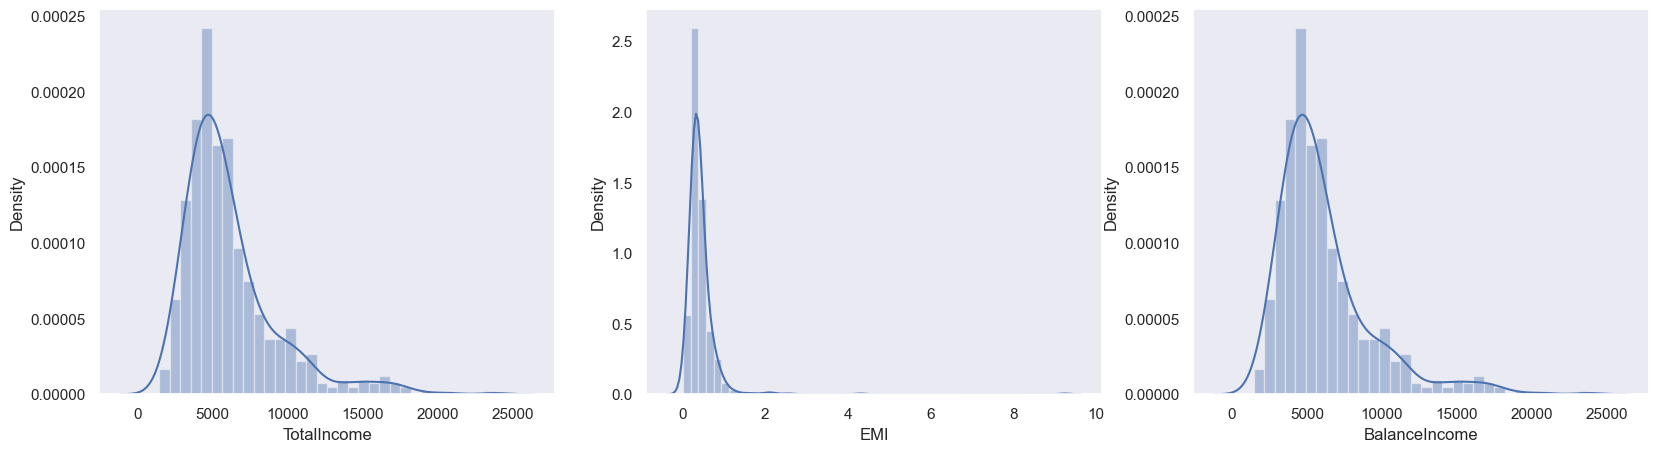

In [57]:
train['TotalIncome']=train['ApplicantIncome']+train['CoapplicantIncome']
train['EMI']=train['LoanAmount']/train['Loan_Amount_Term']
train['BalanceIncome']=train['TotalIncome']-train['EMI']

plt.figure(1,figsize=(20,5))
plt.subplot(1,3,1)
sns.distplot(train['TotalIncome'])
plt.subplot(1,3,2)
sns.distplot(train['EMI'])
plt.subplot(1,3,3)
sns.distplot(train['BalanceIncome'])
plt.show()

In [58]:
test['TotalIncome']=test['ApplicantIncome']+test['CoapplicantIncome']
test['EMI']=test['LoanAmount']/test['Loan_Amount_Term']
test['BalanceIncome']=test['TotalIncome']-test['EMI']

In [59]:
train.drop(['ApplicantIncome','CoapplicantIncome','Loan_Amount_Term','LoanAmount'],axis=1,inplace=True)
test.drop(['ApplicantIncome','CoapplicantIncome','Loan_Amount_Term','LoanAmount'],axis=1,inplace=True)


In [60]:
test.to_csv('../data/predict_format_test.csv',index=False)

# Testing multiple models

In [61]:
x=train.drop('Loan_Status', axis=1)
y=train['Loan_Status']

In [62]:
def model(model_name,feature,target):
    i=1
    kf=StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
    for train_index,test_index in kf.split(x,y):
        print('{} of kfold {}'.format(i,kf.n_splits))
        xtr,xte= x.iloc[train_index],x.iloc[test_index]
        ytr,yte=y.iloc[train_index],y.iloc[test_index]
        
        model=model_name
        model.fit(xtr,ytr)
        pred=model.predict(xte)
        score=accuracy_score(yte,pred)
        print('Accuracy_score: ',score)
        i+=1
        pred=model.predict_proba(xte)[:,1]
    

### Logistic regression

In [63]:
lr = LogisticRegression()
model(lr,x,y)
pred_test=lr.predict(test)
joblib.dump(lr, '../logistic_regression_model.joblib')

1 of kfold 5
Accuracy_score:  0.8151260504201681
2 of kfold 5
Accuracy_score:  0.7966101694915254
3 of kfold 5
Accuracy_score:  0.8220338983050848
4 of kfold 5
Accuracy_score:  0.7966101694915254
5 of kfold 5
Accuracy_score:  0.711864406779661


['../logistic_regression_model.joblib']

In [64]:
submission['Loan_Status']=pred_test
submission['Loan_ID']=test_og['Loan_ID']

# submission['Loan_Status']=submission['Loan_Status'].map({1: 'Yes',0:'No'})
pd.DataFrame(submission).to_csv('../LogisticRegression.csv')

### Decision Tree

In [65]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
dt=DecisionTreeClassifier()

In [66]:
model(dt,x,y)

1 of kfold 5
Accuracy_score:  0.7226890756302521
2 of kfold 5
Accuracy_score:  0.6440677966101694
3 of kfold 5
Accuracy_score:  0.7542372881355932
4 of kfold 5
Accuracy_score:  0.711864406779661
5 of kfold 5
Accuracy_score:  0.711864406779661


In [67]:
pred_test=dt.predict(test)
joblib.dump(dt, '../decision_tree_model.joblib')


['../decision_tree_model.joblib']

In [68]:
# submission['Loan_ID']=test_og['Loan_ID']
submission['Loan_Status']=pred_test
# submission['Gender']=test_og['Gender']
# submission['Race']=test_og['Race']

# submission['Loan_Status']=submission['Loan_Status'].map({1: 'Yes',0:'No'})
pd.DataFrame(submission).to_csv('../DecisionTreeClassifier.csv')

### Random forest

In [69]:
rfc=RandomForestClassifier(max_depth=5,n_estimators=21 ,random_state=1)
model(rfc,x,y)

1 of kfold 5
Accuracy_score:  0.8235294117647058
2 of kfold 5
Accuracy_score:  0.788135593220339
3 of kfold 5
Accuracy_score:  0.8389830508474576
4 of kfold 5
Accuracy_score:  0.8135593220338984
5 of kfold 5
Accuracy_score:  0.8389830508474576


In [70]:
pred_test=rfc.predict(test)
joblib.dump(rfc, '../random_forest_model.joblib')


['../random_forest_model.joblib']

In [71]:
submission['Loan_Status']=pred_test

# submission['Loan_Status']=submission['Loan_Status'].map({1: 'Yes',0:'No'})
pd.DataFrame(submission, columns=['Loan_ID','Loan_Status','Gender', 'Race']).to_csv('../RandomForestClassifier.csv')

# Feature Importance

<Axes: >

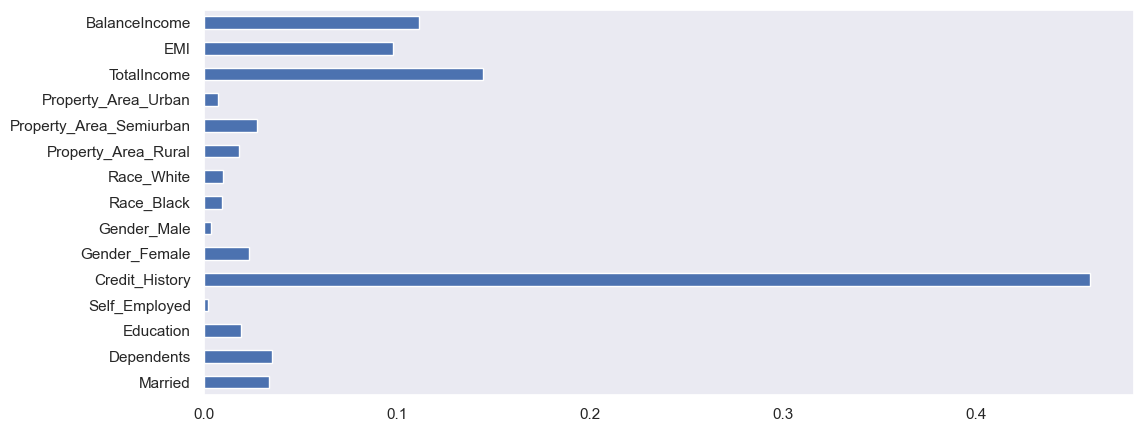

In [72]:
importances=pd.Series(rfc.feature_importances_, index=x.columns)
importances.plot(kind='barh',figsize=(12,5))

# XGB CLassifier

In [73]:
xgb=XGBClassifier()
model(xgb,x,y)
pred_test=xgb.predict(test)
joblib.dump(xgb, '../xgb_model.joblib')


1 of kfold 5


Accuracy_score:  0.8067226890756303
2 of kfold 5
Accuracy_score:  0.7033898305084746
3 of kfold 5
Accuracy_score:  0.8135593220338984
4 of kfold 5
Accuracy_score:  0.7457627118644068
5 of kfold 5
Accuracy_score:  0.8135593220338984


['../xgb_model.joblib']

In [74]:
submission['Loan_Status']=pred_test

# submission['Loan_Status']=submission['Loan_Status'].map({1: 'Yes',0:'No'})
pd.DataFrame(submission, columns=['Loan_ID','Loan_Status','Gender', 'Race']).to_csv('../XGBClassifier.csv')

# Thankyou :)